# LiDAR Uncertainty at SOAP and NEON sites

## The SOAP site
![Soaproot Panorama](img/Soaproot_pano.jpeg)
Image credit: National Ecological Observtory Network, available at: https://www.neonscience.org/field-sites/soap

In [1]:
import os
import pathlib

import earthpy as et
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns
import clean

et.data.get_data('spatial-vector-lidar')

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)
os.chdir(home_dir)

Pseudocode for creating a class
---------------
NEONDataLoader object:

- takes:
      - name of the dataset
      - id column name
      - dictionary of formatting to apply to file paths
      - id modifier
- has:
      - name of dataset
      - id column name
      - paths
      - LiDAR GeoDataFrame (or ability to compute)
      - insitu DataFrame
      - merged GeoDataFrame    
- does:
      - loads LiDAR GeoDataFrame (propertty - also in has)
      - loads insitu DataFrame (propertty - also in has)
      - merged insitu and LiDAR data (propertty - also in has)
      - plot the data
      - (caching)
      - (save the plot to a file)

In [2]:
class NEONDataLoader:
    """
    Parent class to load NEON height data
            
        Attributes
        ----------
        base_dir_tmpl: str
            template for path to base directory
        
        insitu_path_tmpl:
            template for path to insitu directory
        
        chm_path_tmpl: str
            template for path to lidar directory
        
        plots_path_tmpl:
            template for path to plots directory
        
        site_name: str
            name of the site
    
        id_col_name: str
            name of the ID column header
    
        formatting_dict: str
            specific formatting for the site paths
    
        id_modifier: function
            function to modify the values in the id column
            
    """
    # Set as attributes
    base_dir_tmpl = os.path.join(
        'california',
        'neon-{site_name_low}-site')  
    insitu_path_tmpl = os.path.join(
        '{base_dir}',
        '2013',
        'insitu',
        'veg{separator}structure',
        'D17_2013_{site_name_up}_vegStr.csv')
    chm_path_tmpl = os.path.join(
        '{base_dir}',
        '2013',
        'lidar',
        '{site_name_up}_lidarCHM.tif')
    plots_path_tmpl = os.path.join(
        '{base_dir}',
        'vector_data',    
        '{site_name_up}{plot}_centroids.shp')
    
    site_name = NotImplemented
    id_col_name = NotImplemented
    formatting_dict = NotImplemented
    id_modifier = None
    
    def __init__(self):
        # set arguments as attributes
        self.formatting_dict['site_name_low'] = self.site_name.lower()
        self.formatting_dict['site_name_up'] = self.site_name.upper()
        self.formatting_dict['base_dir'] = (
            self.base_dir_tmpl.format(**self.formatting_dict))
       
        self.insitu_path = self.insitu_path_tmpl.format(**self.formatting_dict)
        self.chm_path = self.chm_path_tmpl.format(**self.formatting_dict)
        self.plots_path = self.plots_path_tmpl.format(**self.formatting_dict)
        
        self._insitu_height_stats = None
        self._lidar_chm_stats = None
        self._height_stats = None
        
    # dont need () with property
    @property    
    def lidar_chm_stats(self):
        """
        Calculates max and mean tree height from LiDAR

        Attributes
        ----------
        plots_path: path
            path to the plot shapefile

        chm_paths: path
            path to the lidar CHM data (tif file)

        Returns
        ---------
        self._lidar_chm_stats: gdf
            geodataframe containing max and mean lidar canopy height
        """
        if self._lidar_chm_stats is None:
            # Calculate the plot perimeters
            plots_gdf = gpd.read_file(self.plots_path)
            plots_gdf.geometry = plots_gdf.geometry.buffer(20)

            # Calculate zonal statistics - creates Dictionary
            chm_stats = rs.zonal_stats(
                    plots_gdf, self.chm_path,
                    stats =['mean', 'max'], nodata=0, 
                    geojson_out=True, copy_properties=True)
            # Create GDF with max and mean
            self._lidar_chm_stats = gpd.GeoDataFrame.from_features(chm_stats)
            self._lidar_chm_stats.rename(
                columns={'max': 'lidar_max', 'mean': 'lidar_mean'},
                inplace=True)
            if not self.id_modifier is None:
                self._lidar_chm_stats[self.id_col_name] = (
                    self._lidar_chm_stats[self.id_col_name]
                    .apply(self.id_modifier))
        
        return self._lidar_chm_stats
    
    @property
    def insitu_height_stats(self):
        """
        Calculate max and mean tree height from insitu data
        
        Attributes
        ----------
        insitu_path: path
            path to the insitu data (csv)

        Returns
        ---------
        self._insitu_height_stats: gdf
            dataframe containing max and mean insitu tree height
        """
        if self._insitu_height_stats is None:
            self._insitu_height_stats =(
                pd.read_csv(self.insitu_path)
                .groupby('plotid')
                .stemheight
                .agg(['max', 'mean'])
                .rename(columns={'max': 'insitu_max', 
                                 'mean': 'insitu_mean'}))
        return self._insitu_height_stats
    
    @property
    def height_stats(self):
        """
        Calculate max and mean tree height from lidar and insitu data
    
        Parameters
        ----------
        lidar_chm_stats: property
            Property that creates gdf of LiDAR max and mean tree height

        insitu_height_stats: property
            Property that creates df of insitu max and mean tree height

        Returns
        ---------
        self._height_stats: gdf
            geodataframe containing plot IDs and lidar and insitu
            max and mean canopy height
        """
        if self._height_stats is None:
            self._height_stats = (
                self.lidar_chm_stats
                .merge(self.insitu_height_stats,
                       right_index=True,
                       left_on=self.id_col_name))
        return self._height_stats

In [3]:
# Create child class for SJER
class SJERDataLoader(NEONDataLoader):
    site_name = 'SJER'
    id_col_name = 'Plot_ID'
    formatting_dict = {
        'separator': '_', 
        'plot': '_plot'}

# Create instance of class for sjer (object)   
sjer_data_loader = SJERDataLoader()
sjer_data_loader.height_stats.head()
#sjer_data_loader.lidar_chm_stats() = chm_gdf
#sjer_data_loader.insitu_chm_stats() = insitu_df

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,insitu_max,insitu_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,19.3,3.866667
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,23.9,8.221429
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,16.0,8.218750
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,11.0,6.512500
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,8.8,7.600000


In [4]:
# Child class for SOAP
class SOAPDataLoader(NEONDataLoader):
    
    site_name = 'SOAP'
    id_col_name = 'ID'
    formatting_dict = {
        'separator': '-', 
        'plot': ''}
    
    def id_modifier(self, id):
        return 'SOAP' + str(id)
    
soap_data_loader = SOAPDataLoader()
soap_data_loader.height_stats.head()

,geometry,OBJECTID,ID,plotType,subtype,plotDimens,Protocols,lidar_max,lidar_mean,insitu_max,insitu_mean
1,"POLYGON ((297065.197 4100713.028, 297065.101 4...",2,SOAP43,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",54.099998,19.804080,51.1,5.047000
2,"POLYGON ((299825.197 4101013.028, 299825.101 4...",3,SOAP63,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",32.480000,16.989834,33.0,9.232787
4,"POLYGON ((298715.197 4100833.028, 298715.101 4...",5,SOAP95,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",33.869999,17.412048,28.1,6.050943
5,"POLYGON ((297065.197 4100083.028, 297065.101 4...",6,SOAP139,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",49.919998,19.417840,120.0,4.745902
6,"POLYGON ((299885.197 4100413.028, 299885.101 4...",7,SOAP143,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",27.340000,10.454653,19.7,2.530702


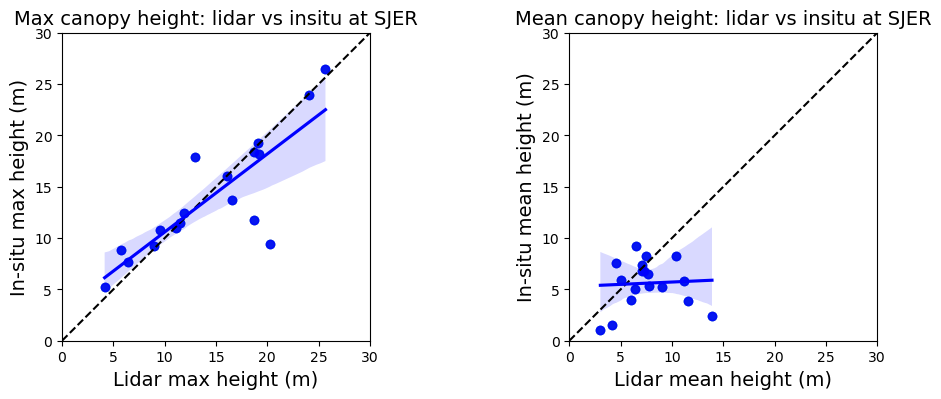

In [8]:
# Function to plot lidar vs insitu man and max height

def plot_height(site_name, plot_gdf, ax1max, ax2max):
    """Plots the insitu vs lidar max and mean canopy height"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    ax1.scatter(plot_gdf.lidar_max, plot_gdf.insitu_max)
    ax1.plot((0,1), (0,1), transform=ax1.transAxes, ls='--', c='k')
    sns.regplot(x='lidar_max', y='insitu_max',
                data=plot_gdf,
                color='blue',
                ax=ax1)
    ax1.set(xlim=(0,ax1max), ylim=(0,ax1max), aspect='equal',
           title=('Max canopy height: lidar vs insitu at {}'
                  .format(site_name)),
           xlabel='Lidar max height (m)',
           ylabel='In-situ max height (m)')
    ax1.xaxis.label.set_fontsize(14)
    ax1.yaxis.label.set_fontsize(14)
    ax1.title.set_fontsize(14)

    ax2.scatter(plot_gdf.lidar_mean, plot_gdf.insitu_mean)
    ax2.plot((0,1), (0,1), transform=ax2.transAxes, ls='--', c='k')
    sns.regplot(x='lidar_mean', y='insitu_mean',
                data=plot_gdf,
                color='blue',
                ax=ax2)
    ax2.set(xlim=(0,ax2max), ylim=(0,ax2max), aspect='equal',
           title=('Mean canopy height: lidar vs insitu at {}'
                  .format(site_name)),
           xlabel='Lidar mean height (m)',
           ylabel='In-situ mean height (m)')
    ax2.xaxis.label.set_fontsize(14)
    ax2.yaxis.label.set_fontsize(14)
    ax2.title.set_fontsize(14)

    plt.show()

# Plot SJER mean and max data
plot_height(site_name='SJER',
           plot_gdf = sjer_data_loader.height_stats,
           ax1max = 30,
           ax2max = 30)

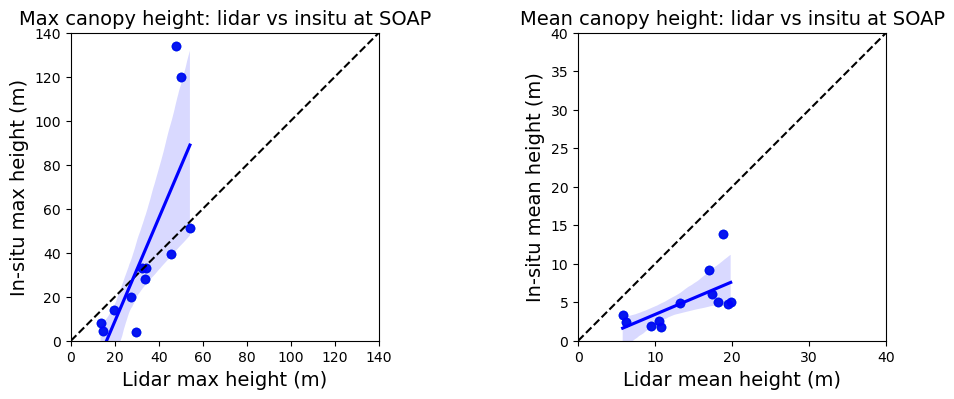

In [9]:
# plot SOAP mean and max data
plot_height(site_name='SOAP',
           plot_gdf = soap_data_loader.height_stats,
           ax1max = 140,
           ax2max = 40)